# Example: PS-DTFE estimator for 3D simulation — basic implementation

In this notebook, the `PS-DTFE_subbox.jl` file is used to apply PS-DTFE estimator to the output of a 3D simulation. With the basic implementation, the algorithm is suitable to small simulations of sizes up to 128^3 particles.

This file demonstrates the evaluation of density, velocity and number of streams field for 3D box or a 2D slice through the simulation.

author: Benjamin Hertzsch (benjamin.hertzsch@ed.ac.uk), Job Feldbrugge (job.feldbrugge@ed.ac.uk)


## Step 1: data preparation

The data are loaded and need to processed for proper field evaluations obeying the periodic boundary conditions.

In [23]:
using JLD2, Plots, HDF5, ProgressMeter

include("PS-DTFE_subbox.jl")

## set up simulation box
Ni = 64
L  = 100.

## load data for particle positions, velocities, and mass
function load_data(file)
    fid = h5open(file, "r")
    pos = convert.(Float64, read(fid["PartType1"]["Coordinates"]))
    vel = convert.(Float64, read(fid["PartType1"]["Velocities"]))
    ids = read(fid["PartType1"]["ParticleIDs"])
    time = read_attribute(fid["Header"], "Time")
    close(fid)

    ordering = sortperm(ids)
    return (copy(pos[:,ordering]'), copy(vel[:,ordering]'), time)
end

function load_mass(file)
    f = h5open(file, "r")
    read_attribute(f["Header"], "MassTable")[2]  # particle type 1
end

m = load_mass("data/snapshot_000.hdf5")
(coords_q, _, _) = load_data("data/snapshot_000.hdf5")
(coords_x, vels, _) = load_data("data/snapshot_002.hdf5")


## process data: unwrapping from periodic boundary conditions and framing coordinates periodically around box
pad  = 0.05

coords_x             = unwrap_x_(coords_q, coords_x, L);          # unwrapping necessary for proper DM sheet identification
coords_q_, coords_x_ = translate(coords_q, coords_x, L)           # preparation for padding
vels_                = frame_velocities(coords_x_, vels, L, pad)  # frame velocities (BEFORE framing coordinates!)
coords_q_, coords_x_ = frame(coords_q_, coords_x_, L, pad);       # framing by small factor * width of box


## Step 2: estimator construction

The estimator is now constructed as a pre-computation step for the field evaluations. This construction is done only once.

For the estimator construction, specify the box boundaries and the depth of the simplex search tree (technical details see https://academic.oup.com/mnras/article/536/1/807/7915986). Higher tree depths yield faster field evaluations, but require longer construction times. It is recommended to start with `depth=5` and increase the depth if required for higher-resolution field evaluations.

The construction time should be of order of a few minutes for a 64^3 simulation at `depth=7`, or a 128^3 simulation at `depth=5`.

To re-use the estimator without re-construction, consider saving it to file.

In [24]:
depth = 7
box = [0 L; 0 L; 0 L]

## construct estimator
ps_dtfe = PS_DTFE(coords_q_, coords_x_, vels_, m, depth, box)

## if want to ignore velocities
#ps_dtfe = PS_DTFE(coords_q, coords_x, zeros(size(v_x)[1], 3), m, depth, box)

## if want to save and reload constructed estimator
save("ps-dtfe.jld2", "ps-dtfe", ps_dtfe)
ps_dtfe = load("ps-dtfe.jld2")["ps-dtfe"]

## Step 3: fields evaluation

Density fields are evaluated with the `density()`-function.

We now evaluate the density field for the x-, y- and z-slice through the centre of the simulation box.

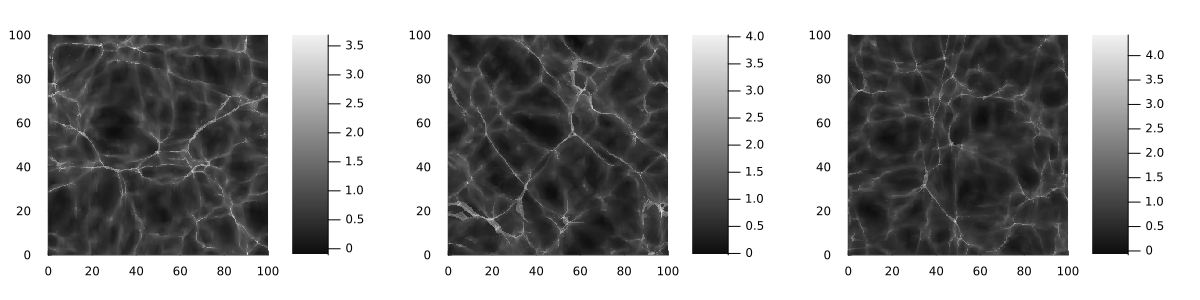

In [25]:
Range = 0.:0.2:100.

density_a = @showprogress [density([L/2., y, z], ps_dtfe) for y in Range, z in Range]
density_b = @showprogress [density([x, L/2., z], ps_dtfe) for x in Range, z in Range]
density_c = @showprogress [density([x, y, L/2.], ps_dtfe) for x in Range, y in Range];

p1 = heatmap(Range, Range, log10.(density_a), aspect_ratio=:equal, xlims=(0, L), ylims=(0, L), c=:grays)
p2 = heatmap(Range, Range, log10.(density_b), aspect_ratio=:equal, xlims=(0, L), ylims=(0, L), c=:grays)
p3 = heatmap(Range, Range, log10.(density_c), aspect_ratio=:equal, xlims=(0, L), ylims=(0, L), c=:grays)
plot(p1, p2, p3, layout = grid(1, 3), size=(1200, 300))

Let's look a zoom-in of a high-density region (where the density resolution is here limited by the triangulation by the low-resolution simulation):

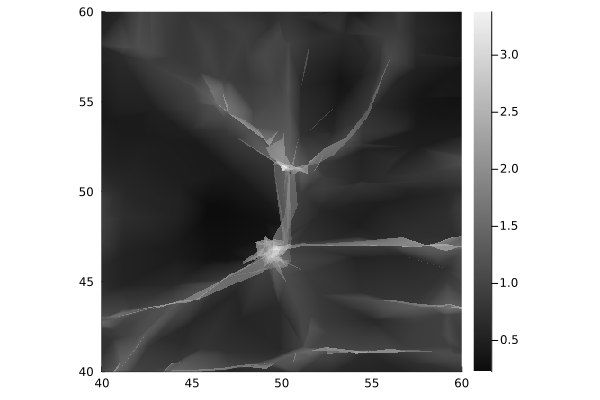

In [26]:
zoomRange = 40.:0.05:60.

density_zoom = @showprogress [density([L/2., y, z], ps_dtfe) for y in zoomRange, z in zoomRange]

heatmap(zoomRange, zoomRange, log10.(density_zoom), aspect_ratio=:equal, xlims=(40., 60.), ylims=(40., 60.), c=:grays)

The number of streams are evaluated analogously with the `numberOfStreams()`-function:

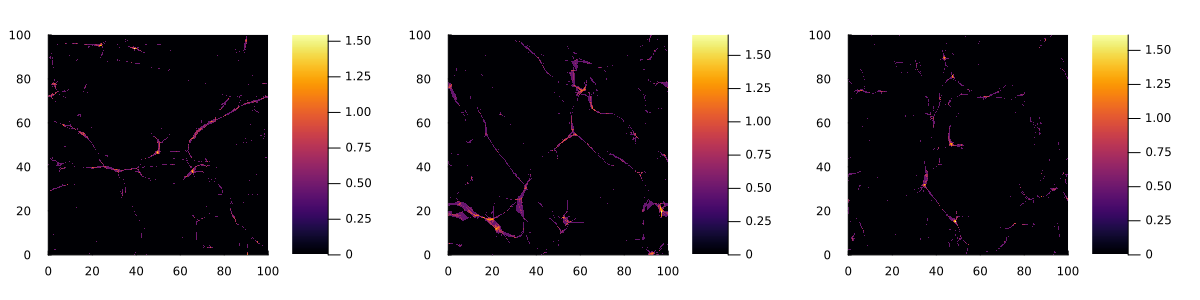

In [27]:
Range = 0.:0.2:100.

nstreams_a = @showprogress [numberOfStreams([L/2., y, z], ps_dtfe) for y in Range, z in Range]
nstreams_b = @showprogress [numberOfStreams([x, L/2., z], ps_dtfe) for x in Range, z in Range]
nstreams_c = @showprogress [numberOfStreams([x, y, L/2.], ps_dtfe) for x in Range, y in Range];

p1 = heatmap(Range, Range, log10.(nstreams_a), aspect_ratio=:equal, xlims=(0, L), ylims=(0, L))
p2 = heatmap(Range, Range, log10.(nstreams_b), aspect_ratio=:equal, xlims=(0, L), ylims=(0, L))
p3 = heatmap(Range, Range, log10.(nstreams_c), aspect_ratio=:equal, xlims=(0, L), ylims=(0, L))
plot(p1, p2, p3, layout = grid(1, 3), size=(1200, 300))

Velocity fields are evaluated with the `velocity()`-function.

In [28]:
vel_a = @showprogress [velocity([L/2., y, z], ps_dtfe) for y in Range, z in Range]
#vel_a = [velocity([L/2., y, z], ps_dtfe, true) for y in Range, z in Range]   # return NaN if not single-streaming

501×501 Matrix{Matrix{Float64}}:
 [20.7923 -68.3154 26.7559]    …  [20.7923 -68.3154 26.7559]
 [20.0133 -66.183 24.3481]        [20.0133 -66.183 24.3481]
 [19.2342 -64.0506 21.9404]       [19.2342 -64.0506 21.9404]
 [22.8611 -82.6256 11.4635]       [29.5419 -77.6228 12.427]
 [23.5606 -79.286 9.02163]        [30.2414 -74.2832 9.98515]
 [24.2602 -75.9464 6.57978]    …  [30.941 -70.9436 7.54331]
 [24.9597 -72.6068 4.13793]       [31.6405 -67.604 5.10146]
 [25.6593 -69.2672 1.69609]       [32.3401 -64.2645 2.65961]
 [26.3588 -65.9276 -0.745761]     [33.0396 -60.9249 0.217766]
 [27.0584 -62.588 -3.18761]       [33.7392 -57.5853 -2.22408]
 ⋮                             ⋱  ⋮
 [33.8998 -99.3862 39.8176]       [23.5238 -119.438 41.8641]
 [31.2306 -95.9372 38.4274]       [20.8546 -115.989 40.4739]
 [20.5576 -109.429 34.7492]       [34.5435 -106.983 31.5999]
 [17.9504 -105.899 33.2457]    …  [31.9363 -103.453 30.0963]
 [15.3433 -102.368 31.7421]       [29.3292 -99.9225 28.5927]
 [22.7914 -92.7107

Note that in the multistream regions, the `velocity()`-function returns the velocities of the individual streams (or NaN if `single_stream=true` is set in the function). To obtain the stream-mass weighted summation of the velocities, call the `velocitySum()`-function (reducing to `velocity()` in single-stream regions):

In [29]:
vel_a = @showprogress [velocitySum([L/2., y, z], ps_dtfe) for y in Range, z in Range]

501×501 Matrix{Matrix{Float64}}:
 [20.7923 -68.3154 26.7559]    …  [20.7923 -68.3154 26.7559]
 [20.0133 -66.183 24.3481]        [20.0133 -66.183 24.3481]
 [19.2342 -64.0506 21.9404]       [19.2342 -64.0506 21.9404]
 [22.8611 -82.6256 11.4635]       [29.5419 -77.6228 12.427]
 [23.5606 -79.286 9.02163]        [30.2414 -74.2832 9.98515]
 [24.2602 -75.9464 6.57978]    …  [30.941 -70.9436 7.54331]
 [24.9597 -72.6068 4.13793]       [31.6405 -67.604 5.10146]
 [25.6593 -69.2672 1.69609]       [32.3401 -64.2645 2.65961]
 [26.3588 -65.9276 -0.745761]     [33.0396 -60.9249 0.217766]
 [27.0584 -62.588 -3.18761]       [33.7392 -57.5853 -2.22408]
 ⋮                             ⋱  ⋮
 [33.8998 -99.3862 39.8176]       [23.5238 -119.438 41.8641]
 [31.2306 -95.9372 38.4274]       [20.8546 -115.989 40.4739]
 [20.5576 -109.429 34.7492]       [34.5435 -106.983 31.5999]
 [17.9504 -105.899 33.2457]    …  [31.9363 -103.453 30.0963]
 [15.3433 -102.368 31.7421]       [29.3292 -99.9225 28.5927]
 [22.7914 -92.7107

Finally, three-dimensional fields are simply evaluated as for example:

In [30]:
smallRange = 25.:1.:75.

@showprogress [density([x, y, z], ps_dtfe) for x in smallRange, y in smallRange, z in smallRange]

51×51×51 Array{Float64, 3}:
[:, :, 1] =
  7.60942   6.44183   5.41233   5.45091  …   7.8528    9.18011  14.5055
 17.7031   20.171    20.6347   31.4986       7.21266   7.7461   10.5949
  7.31283   6.80934   6.30585   7.22703      5.80569   5.70615   7.94998
  4.99419   4.71845   4.44271   4.54911      3.3921    4.02844   5.74701
  5.02509   4.95155   3.59177   3.77401      2.84542   2.59168   2.48404
  3.62362   3.46783   3.33881   3.54292  …   2.34062   2.20227   2.02805
  3.01527   2.58188   2.23023   2.48599      2.18046   1.9471    1.79022
  3.54856   2.14064   1.88068   1.87479      2.01648   1.74755   1.72582
  2.45559   1.81951   1.67202   1.61638      1.85667   1.54989   1.60247
  1.79203   1.63724   1.48244   1.42276      1.96656   1.3837    1.43734
  ⋮                                      ⋱                       ⋮
  3.01059   2.89134   2.97474   3.17103      7.62332   5.63864   5.10451
  2.93456   3.00582   3.12273   3.17115      9.61092   8.40204   7.01221
  2.17469   2.22821

## Supplementary: DTFE comparison

The ordinary DTFE fields are obtained by constructing the estimator only on the Eulerian fields, e.g.:

In [31]:
depth = 7
box = [0 L; 0 L; 0 L]

dtfe = PS_DTFE(coords_x_, coords_x_, vels_, m, depth, box)

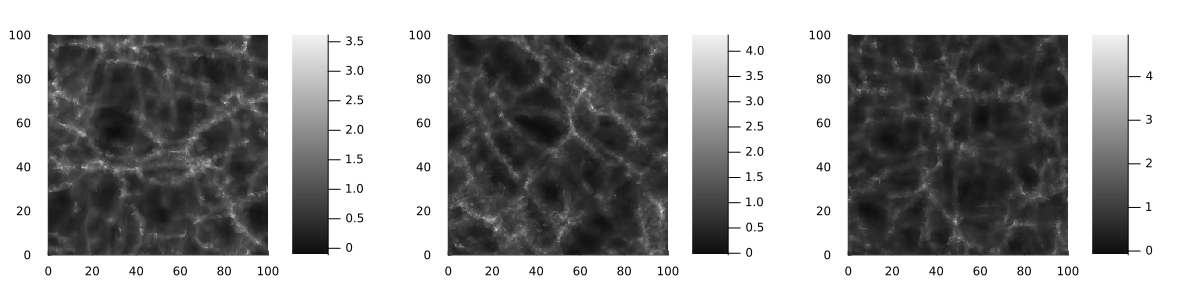

In [32]:
Range = 0.:0.2:100.

density_a_dtfe = @showprogress [density([L/2., y, z], dtfe) for y in Range, z in Range]
density_b_dtfe = @showprogress [density([x, L/2., z], dtfe) for x in Range, z in Range]
density_c_dtfe = @showprogress [density([x, y, L/2.], dtfe) for x in Range, y in Range];

p1 = heatmap(Range, Range, log10.(density_a_dtfe), aspect_ratio=:equal, xlims=(0, L), ylims=(0, L), c=:grays)
p2 = heatmap(Range, Range, log10.(density_b_dtfe), aspect_ratio=:equal, xlims=(0, L), ylims=(0, L), c=:grays)
p3 = heatmap(Range, Range, log10.(density_c_dtfe), aspect_ratio=:equal, xlims=(0, L), ylims=(0, L), c=:grays)
plot(p1, p2, p3, layout = grid(1, 3), size=(1200, 300))

The zoomed region reveals the qualitative difference:

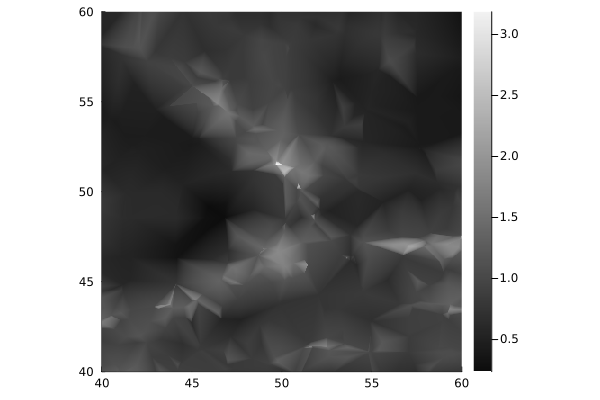

In [33]:
zoomRange = 40.:0.05:60.

density_zoom_dtfe = @showprogress [density([L/2., y, z], dtfe) for y in zoomRange, z in zoomRange]

heatmap(zoomRange, zoomRange, log10.(density_zoom_dtfe), aspect_ratio=:equal, xlims=(40., 60.), ylims=(40., 60.), c=:grays)